# STORM

[STORM](https://arxiv.org/abs/2402.14207) is a research assistant designed by Shao, et. al that extends the idea of "outline-driven RAG" for richer article generation.

STORM is designed to generate Wikipedia-style ariticles on a user-provided topic. It applies two main insights to produce more organized and comprehensive articles:

1. Creating an outline (planning) by querying similar topics helps improve coverage.
2. Multi-perspective, grounded (in search) conversation simulation helps increase the reference count and information density. 

The control flow looks like the diagram below.

![STORM diagram](./img/storm.png)

STORM has a few main stages:

1. Generate initial outline + Survey related subjects
2. Identify distinct perspectives
3. "Interview subject matter experts" (role-playing LLMs)
4. Refine outline (using references)
5. Write sections, then write article


The expert interviews stage ocurrs between the role-playing article writer and a research expert. The "expert" is able to query external knowledge and respond to pointed questions, saving cited sources to a vectorstore so that the later refinement stages can synthesize the full article.

There are a couple hyperparameters you can set to restrict the (potentially) infinite research breadth:

N: Number of perspectives to survey / use (Steps 2->3)
M: Max number of conversation turns in step (Step 3)


## Prerequisites

In [1]:
# %pip install -U langchain_community langchain_openai langgraph wikipedia  scikit-learn  langchain_fireworks
# We use one or the other search engine below
# %pip install -U duckduckgo tavily-python

In [2]:
# Uncomment if you want to draw the pretty graph diagrams.
# If you are on MacOS, you will need to run brew install graphviz before installing and update some environment flags
# ! brew install graphviz
# !CFLAGS="-I $(brew --prefix graphviz)/include" LDFLAGS="-L $(brew --prefix graphviz)/lib" pip install -U pygraphviz

In [86]:
import os
import getpass


def _set_env(var: str):
    if os.environ.get(var):
        return
    os.environ[var] = getpass.getpass(var + ":")


# Set for tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "STORM"
_set_env("LANGCHAIN_API_KEY")
_set_env("OPENAI_API_KEY")

#### Select LLMs

We will have a faster LLM do most of the work, but a slower, long-context model to distill the conversations and write the final report.

In [3]:
from langchain_openai import ChatOpenAI
from langchain_fireworks import ChatFireworks

fast_llm = ChatOpenAI(model="gpt-3.5-turbo")
# Uncomment for a Fireworks model
# fast_llm = ChatFireworks(model="accounts/fireworks/models/firefunction-v1", max_tokens=32_000)
long_context_llm = ChatOpenAI(model="gpt-4-turbo-preview")

## Generate Initial Outline

For many topics, your LLM may have an initial idea of the important and related topics. We can generate an initial
outline to be refined after our research. Below, we will use our "fast" llm to generate the outline.

In [4]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Optional
from langchain_core.prompts import ChatPromptTemplate

direct_gen_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a Wikipedia writer. Write an outline for a Wikipedia page about a user-provided topic. Be comprehensive and specific.",
        ),
        ("user", "{topic}"),
    ]
)


class Subsection(BaseModel):
    subsection_title: str = Field(..., title="Title of the subsection")
    description: str = Field(..., title="Content of the subsection")

    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.description}".strip()


class Section(BaseModel):
    section_title: str = Field(..., title="Title of the section")
    description: str = Field(..., title="Content of the section")
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title="Titles and descriptions for each subsection of the Wikipedia page.",
    )

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            f"### {subsection.subsection_title}\n\n{subsection.description}"
            for subsection in self.subsections or []
        )
        return f"## {self.section_title}\n\n{self.description}\n\n{subsections}".strip()


class Outline(BaseModel):
    page_title: str = Field(..., title="Title of the Wikipedia page")
    sections: List[Section] = Field(
        default_factory=list,
        title="Titles and descriptions for each section of the Wikipedia page.",
    )

    @property
    def as_str(self) -> str:
        sections = "\n\n".join(section.as_str for section in self.sections)
        return f"# {self.page_title}\n\n{sections}".strip()


generate_outline_direct = direct_gen_outline_prompt | fast_llm.with_structured_output(
    Outline
)

/Users/wfh/code/lc/langchain/libs/core/langchain_core/_api/beta_decorator.py:86: LangChainBetaWarning: The function `with_structured_output` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


In [5]:
example_topic = "Impact of million-plus token context window language models on RAG"

initial_outline = generate_outline_direct.invoke({"topic": example_topic})

print(initial_outline.as_str)

# Impact of million-plus token context window language models on RAG

## Introduction

Overview of million-plus token context window language models and RAG (Retrieval-Augmented Generation).

## Million-Plus Token Context Window Language Models

Explanation of million-plus token context window language models, their architecture, training data, and applications.

## RAG (Retrieval-Augmented Generation)

Overview of RAG, its architecture, how it combines retrieval and generation models, and its use in natural language processing tasks.

## Impact on RAG

Discuss the impact of million-plus token context window language models on RAG, including improvements in performance, efficiency, and challenges faced.


## Expand Topics

While language models do store some Wikipedia-like knowledge in their parameters, you will get better results by incorporating relevant and recent information using a search engine.

We will start our search by generating a list of related topics, sourced from Wikipedia.

In [6]:
gen_related_topics_prompt = ChatPromptTemplate.from_template(
    """I'm writing a Wikipedia page for a topic mentioned below. Please identify and recommend some Wikipedia pages on closely related subjects. I'm looking for examples that provide insights into interesting aspects commonly associated with this topic, or examples that help me understand the typical content and structure included in Wikipedia pages for similar topics.

Please list the as many subjects and urls as you can.

Topic of interest: {topic}
"""
)


class RelatedSubjects(BaseModel):
    topics: List[str] = Field(
        description="Comprehensive list of related subjects as background research.",
    )


expand_chain = gen_related_topics_prompt | fast_llm.with_structured_output(
    RelatedSubjects
)

In [7]:
related_subjects = await expand_chain.ainvoke({"topic": example_topic})
related_subjects

RelatedSubjects(topics=['Language models', 'Retriever-Reader-Generator (RAG) model', 'Natural language processing', 'Machine learning', 'Artificial intelligence', 'Text generation', 'Transformer architecture', 'Context window', 'Impact of language models'])

## Generate Perspectives

From these related subjects, we can select representative Wikipedia editors as "subject matter experts" with distinct
backgrounds and affiliations. These will help distribute the search process to encourage a more well-rounded final report.

In [8]:
class Editor(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the editor.",
    )
    name: str = Field(
        description="Name of the editor.",
    )
    role: str = Field(
        description="Role of the editor in the context of the topic.",
    )
    description: str = Field(
        description="Description of the editor's focus, concerns, and motives.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"


class Perspectives(BaseModel):
    editors: List[Editor] = Field(
        description="Comprehensive list of editors with their roles and affiliations.",
        # Add a pydantic validation/restriction to be at most M editors
    )


gen_perspectives_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You need to select a diverse (and distinct) group of Wikipedia editors who will work together to create a comprehensive article on the topic. Each of them represents a different perspective, role, or affiliation related to this topic.\
    You can use other Wikipedia pages of related topics for inspiration. For each editor, add a description of what they will focus on.

    Wiki page outlines of related topics for inspiration:
    {examples}""",
        ),
        ("user", "Topic of interest: {topic}"),
    ]
)

gen_perspectives_chain = gen_perspectives_prompt | ChatOpenAI(
    model="gpt-3.5-turbo"
).with_structured_output(Perspectives)

In [9]:
from langchain_community.retrievers import WikipediaRetriever
from langchain_core.runnables import RunnableLambda, chain as as_runnable

wikipedia_retriever = WikipediaRetriever(load_all_available_meta=True, top_k_results=1)


def format_doc(doc, max_length=1000):
    related = "- ".join(doc.metadata["categories"])
    return f"### {doc.metadata['title']}\n\nSummary: {doc.page_content}\n\nRelated\n{related}"[
        :max_length
    ]


def format_docs(docs):
    return "\n\n".join(format_doc(doc) for doc in docs)


@as_runnable
async def survey_subjects(topic: str):
    related_subjects = await expand_chain.ainvoke({"topic": topic})
    retrieved_docs = await wikipedia_retriever.abatch(
        related_subjects.topics, return_exceptions=True
    )
    all_docs = []
    for docs in retrieved_docs:
        if isinstance(docs, BaseException):
            continue
        all_docs.extend(docs)
    formatted = format_docs(all_docs)
    return await gen_perspectives_chain.ainvoke({"examples": formatted, "topic": topic})

In [11]:
perspectives = await survey_subjects.ainvoke(example_topic)

In [12]:
perspectives.dict()

{'editors': [{'affiliation': 'Academic Research',
   'name': 'Dr. Linguist',
   'role': 'Language Model Expert',
   'description': 'Dr. Linguist will focus on explaining the technical aspects of million-plus token context window language models and their impact on RAG (Retrieval-Augmented Generation) systems.'},
  {'affiliation': 'Industry',
   'name': 'TechTrendz',
   'role': 'AI Solutions Architect',
   'description': 'TechTrendz will provide insights on the practical applications of million-plus token context window language models in RAG systems and discuss their benefits and challenges in real-world scenarios.'},
  {'affiliation': 'Open Source Community',
   'name': 'CodeGenius',
   'role': 'Machine Learning Enthusiast',
   'description': 'CodeGenius will explore the open-source tools and frameworks available for implementing million-plus token context window language models in RAG systems and share their experiences with the community.'},
  {'affiliation': 'Tech Journalism',
   '

## Expert Dialog

Now the true fun begins, each wikipedia writer is primed to role-play using the perspectives presented above. It will ask a series of questions of a second "domain expert" with access to a search engine. This generate content to generate a refined outline as well as an updated index of reference documents.


### Interview State

The conversation is cyclic, so we will construct it within its own graph. The State will contain messages, the reference docs, and the editor (with its own "persona") to make it easy to parallelize these conversations.

In [13]:
from langgraph.graph import StateGraph, END
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated, Sequence


def add_messages(left, right):
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    return left + right


def update_references(references, new_references):
    if not references:
        references = {}
    references.update(new_references)
    return references


def update_editor(editor, new_editor):
    # Can only set at the outset
    if not editor:
        return new_editor
    return editor


class InterviewState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    references: Annotated[Optional[dict], update_references]
    editor: Annotated[Optional[Editor], update_editor]

#### Dialog Roles

The graph will have two participants: the wikipedia editor (`generate_question`), who asks questions based on its assigned role, and a domain expert (`gen_answer_chain), who uses a search engine to answer the questions as accurately as possible.

In [14]:
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage


gen_qn_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an experienced Wikipedia writer and want to edit a specific page. \
Besides your identity as a Wikipedia writer, you have a specific focus when researching the topic. \
Now, you are chatting with an expert to get information. Ask good questions to get more useful information.

When you have no more questions to ask, say "Thank you so much for your help!" to end the conversation.\
Please only ask one question at a time and don't ask what you have asked before.\
Your questions should be related to the topic you want to write.
Be comprehensive and curious, gaining as much unique insight from the expert as possible.\

Stay true to your specific perspective:

{persona}""",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)


def tag_with_name(ai_message: AIMessage, name: str):
    ai_message.name = name
    return ai_message


def swap_roles(state: InterviewState, name: str):
    converted = []
    for message in state["messages"]:
        if isinstance(message, AIMessage) and message.name != name:
            message = HumanMessage(**message.dict(exclude={"type"}))
        converted.append(message)
    return {"messages": converted}


@as_runnable
async def generate_question(state: InterviewState):
    editor = state["editor"]
    gn_chain = (
        RunnableLambda(swap_roles).bind(name=editor.name)
        | gen_qn_prompt.partial(persona=editor.persona)
        | fast_llm
        | RunnableLambda(tag_with_name).bind(name=editor.name)
    )
    result = await gn_chain.ainvoke(state)
    return {"messages": [result]}

In [15]:
messages = [
    HumanMessage(f"So you said you were writing an article on {example_topic}?")
]
question = await generate_question.ainvoke(
    {
        "editor": perspectives.editors[0],
        "messages": messages,
    }
)

question["messages"][0].content

"Yes, that's correct. I'm focusing on the technical aspects of million-plus token context window language models and their impact on Retrieval-Augmented Generation (RAG) systems. Can you provide more information on how these large context window language models are trained and how they differ from traditional models in the context of RAG systems?"

#### Answer questions

The `gen_answer_chain` first generates queries (query expansion) to answer the editor's question, then responds with citations.

In [16]:
class Queries(BaseModel):
    queries: List[str] = Field(
        description="Comprehensive list of search engine queries to answer the user's questions.",
    )


gen_queries_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful research assistant. Query the search engine to answer the user's questions.",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)
gen_queries_chain = gen_queries_prompt | ChatOpenAI(
    model="gpt-3.5-turbo"
).with_structured_output(Queries, include_raw=True)

In [17]:
queries = await gen_queries_chain.ainvoke(
    {"messages": [HumanMessage(content=question["messages"][0].content)]}
)
queries["parsed"].queries

['Training process of million-plus token context window language models',
 'Differences between large context window language models and traditional models in Retrieval-Augmented Generation systems']

In [43]:
class AnswerWithCitations(BaseModel):
    answer: str = Field(
        description="Comprehensive answer to the user's question with citations.",
    )
    cited_urls: List[str] = Field(
        description="List of urls cited in the answer.",
    )

    @property
    def as_str(self) -> str:
        return f"{self.answer}\n\nCitations:\n\n" + "\n".join(
            f"[{i+1}]: {url}" for i, url in enumerate(self.cited_urls)
        )


gen_answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert who can use information effectively. You are chatting with a Wikipedia writer who wants\
 to write a Wikipedia page on the topic you know. You have gathered the related information and will now use the information to form a response.

Make your response as informative as possible and make sure every sentence is supported by the gathered information.
Each response must be backed up by a citation from a reliable source, formatted as a footnote, reproducing the URLS after your response.""",
        ),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)

gen_answer_chain = gen_answer_prompt | fast_llm.with_structured_output(
    AnswerWithCitations, include_raw=True
).with_config(run_name="GenerateAnswer")

In [19]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.duckduckgo_search import DuckDuckGoSearchAPIWrapper
from langchain_core.tools import tool

search_engine = DuckDuckGoSearchAPIWrapper()
# Tavily is typically a better search engine, but your free queries are limited
# search_engine = TavilySearchResults(max_results=4)


@tool
async def search_engine(query: str):
    """Search engine to the internet."""
    results = DuckDuckGoSearchAPIWrapper()._ddgs_text(query)
    return [{"content": r["body"], "url": r["href"]} for r in results]

In [20]:
from langchain_core.runnables import RunnableConfig
import json


async def gen_answer(
    state: InterviewState,
    config: RunnableConfig | None = None,
    name: str = "Subject Matter Expert",
    max_str_len: int = 15000,
):
    swapped_state = swap_roles(state, name)  # Convert all other AI messages
    queries = await gen_queries_chain.ainvoke(swapped_state)
    query_results = await search_engine.abatch(
        queries["parsed"].queries, config, return_exceptions=True
    )
    successful_results = [
        res for res in query_results if not isinstance(res, Exception)
    ]
    all_query_results = {
        res["url"]: res["content"] for results in successful_results for res in results
    }
    # We could be more precise about handling max token length if we wanted to here
    dumped = json.dumps(all_query_results)[:max_str_len]
    ai_message: AIMessage = queries["raw"]
    tool_call = queries["raw"].additional_kwargs["tool_calls"][0]
    tool_id = tool_call["id"]
    tool_message = ToolMessage(tool_call_id=tool_id, content=dumped)
    swapped_state["messages"].extend([ai_message, tool_message])
    # Only update the shared state with the final answer to avoid
    # polluting the dialogue history with intermediate messages
    generated = await gen_answer_chain.ainvoke(swapped_state)
    cited_urls = set(generated["parsed"].cited_urls)
    # Save the retrieved information to a the shared state for future reference
    cited_references = {k: v for k, v in all_query_results.items() if k in cited_urls}
    formatted_message = AIMessage(name=name, content=generated["parsed"].as_str)
    return {"messages": [formatted_message], "references": cited_references}

In [21]:
example_answer = await gen_answer(
    {"messages": [HumanMessage(content=question["messages"][0].content)]}
)
example_answer["messages"][-1].content

'Large context window language models, such as the Llama2 70B model, can support context windows of more than 100k tokens without continual training through innovations like Dual Chunk Attention (DCA). These models have significantly longer context windows compared to traditional models, with capabilities like processing up to 1 million tokens at once, providing more consistent and relevant outputs. Training these models often involves starting with a smaller window size and gradually increasing it through fine-tuning on larger windows. In contrast, traditional models have much shorter context windows, limiting their ability to process extensive information in a prompt. Retrieval-Augmented Generation (RAG) systems, on the other hand, integrate large language models with external knowledge sources to enhance their performance, offering a pathway to combine the capabilities of models like ChatGPT/GPT-4 with custom data sources for more informed and contextually aware outputs.\n\nCitation

#### Construct the Interview Graph


Now that we've defined the editor and domain expert, we can compose them in a graph.

In [45]:
max_num_turns = 5


def route_messages(state: InterviewState, name: str = "Subject Matter Expert"):
    messages = state["messages"]
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )
    if num_responses >= max_num_turns:
        return END
    last_question = messages[-2]
    if last_question.content.endswith("Thank you so much for your help!"):
        return END
    return "ask_question"


builder = StateGraph(InterviewState)

builder.add_node("ask_question", generate_question)
builder.add_node("answer_question", gen_answer)
builder.add_conditional_edges("answer_question", route_messages)
builder.add_edge("ask_question", "answer_question")

builder.set_entry_point("ask_question")
interview_graph = builder.compile().with_config(run_name="Conduct Interviews")

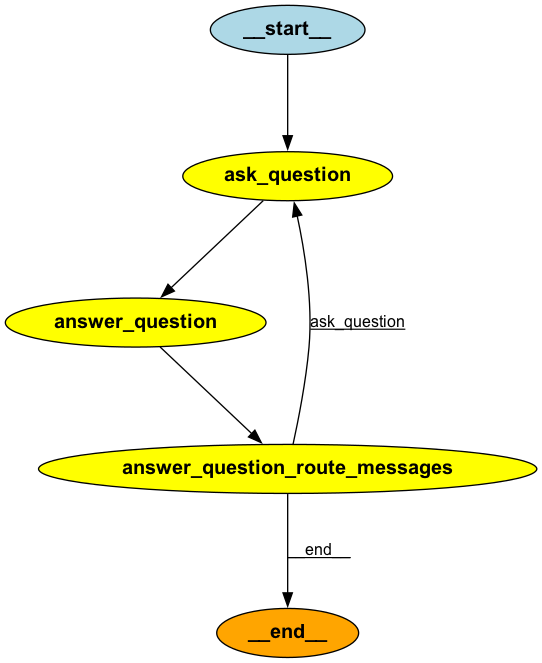

In [46]:
from IPython.display import Image

# Feel free to comment out if you have
# not installed pygraphviz
Image(interview_graph.get_graph().draw_png())

In [23]:
final_step = None

initial_state = {
    "editor": perspectives.editors[0],
    "messages": [
        AIMessage(
            content=f"So you said you were writing an article on {example_topic}?",
            name="Subject Matter Expert",
        )
    ],
}
async for step in interview_graph.astream(initial_state):
    name = next(iter(step))
    print(name)
    print("-- ", str(step[name]["messages"])[:300])
    if END in step:
        final_step = step

ask_question
--  [AIMessage(content="Yes, that's correct. I am focusing on the technical aspects of million-plus token context window language models and their impact on RAG systems. Can you provide more insight into how these large context window models affect the performance and capabilities of RAG systems?", name
answer_question
--  [AIMessage(content='The introduction of large context window language models, such as Gemini 1.5 with a 1 million token context window, has raised concerns in the AI community regarding its impact on Retrieval-Augmented Generation (RAG) systems. RAG systems represent a significant advancement over t
ask_question
--  [AIMessage(content='Thank you for the detailed explanation and resources. Could you elaborate on the specific challenges and opportunities that million-plus token context window language models present for RAG systems in terms of improving generation quality, addressing data biases, and the potentia
answer_question
--  [AIMessage(content='Mil

In [24]:
final_state = next(iter(final_step.values()))

## Refine Outline

At this point in STORM, we've conducted a large amount of research from different perspectives. It's time to refine the original outline based on these investigations. Below, create a chain using the LLM with a long context window to update the original outline.

In [53]:
refine_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a Wikipedia writer. You have gathered information from experts and search engines. Now, you are refining the outline of the Wikipedia page. \
You need to make sure that the outline is comprehensive and specific. \
Topic you are writing about: {topic} 

Old outline:

{old_outline}""",
        ),
        (
            "user",
            "Refine the outline based on your conversations with subject-matter experts:\n\nConversations:\n\n{conversations}\n\nWrite the refined Wikipedia outline:",
        ),
    ]
)

# Using turbo preview since the context can get quite long
refine_outline_chain = refine_outline_prompt | long_context_llm.with_structured_output(
    Outline
)

In [26]:
refined_outline = refine_outline_chain.invoke(
    {
        "topic": example_topic,
        "old_outline": initial_outline.as_str,
        "conversations": "\n\n".join(
            f"### {m.name}\n\n{m.content}" for m in final_state["messages"]
        ),
    }
)

In [27]:
print(refined_outline.as_str)

# Impact of million-plus token context window language models on RAG

## Introduction

Provides a brief overview of million-plus token context window language models and their relevance to Retrieval-Augmented Generation (RAG) systems, setting the stage for a deeper exploration of their impact.

## Background

A foundational section to understand the core concepts involved.

### Million-Plus Token Context Window Language Models

Explains what million-plus token context window language models are, including notable examples like Gemini 1.5, focusing on their architecture, training data, and the evolution of their applications.

### Retrieval-Augmented Generation (RAG)

Describes the RAG framework, its unique approach of combining retrieval and generation models for enhanced natural language processing, and its significance in the AI landscape.

## Impact on RAG Systems

Delves into the effects of million-plus token context window language models on RAG, highlighting both the challenges a

## Generate Article

Now it's time to generate the full article. We will first divide-and-conquer, so that each section can be tackled by an individual llm. Then we will prompt the long-form LLM to refine the finished article (since each section may use an inconsistent voice).

#### Create Retriever

The research process uncovers a large number of reference documents that we may want to query during the final article-writing process.

First, create the retriever:

In [28]:
from langchain_core.documents import Document

from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
reference_docs = [
    Document(page_content=v, metadata={"source": k})
    for k, v in final_state["references"].items()
]
# This really doesn't need to be a vectorstore for this size of data.
# It could just be a numpy matrix. Or you could store documents
# across requests if you want.
vectorstore = SKLearnVectorStore.from_documents(
    reference_docs,
    embedding=embeddings,
)
retriever = vectorstore.as_retriever(k=10)

In [29]:
retriever.invoke("What's a long context LLM anyway?")

[Document(page_content='In Retrieval Augmented Generation (RAG), a longer context augments our model with more information. For LLMs that power agents, such as chatbots, longer context means more tools and capabilities. When summarizing, longer context means more comprehensive summaries. There exist plenty of use-cases for LLMs that are unlocked by longer context lengths.', metadata={'id': '20454848-23ac-4649-b083-81980532a77b', 'source': 'https://www.anyscale.com/blog/fine-tuning-llms-for-longer-context-and-better-rag-systems'}),
 Document(page_content='By the way, the context limits differ among models: two Claude models offer a 100K token context window, which works out to about 75,000 words, which is much higher than most other LLMs. The ...', metadata={'id': '1ee2d2bb-8f8e-4a7e-b45e-608b0804fe4c', 'source': 'https://www.infoworld.com/article/3712227/what-is-rag-more-accurate-and-reliable-llms.html'}),
 Document(page_content='Figure 1: LLM response accuracy goes down when context n

#### Generate Sections

Now you can generate the sections using the indexed docs.

In [30]:
class SubSection(BaseModel):
    subsection_title: str = Field(..., title="Title of the subsection")
    content: str = Field(
        ...,
        title="Full content of the subsection. Include [#] citations to the cited sources where relevant.",
    )

    @property
    def as_str(self) -> str:
        return f"### {self.subsection_title}\n\n{self.content}".strip()


class WikiSection(BaseModel):
    section_title: str = Field(..., title="Title of the section")
    content: str = Field(..., title="Full content of the section")
    subsections: Optional[List[Subsection]] = Field(
        default=None,
        title="Titles and descriptions for each subsection of the Wikipedia page.",
    )
    citations: List[str] = Field(default_factory=list)

    @property
    def as_str(self) -> str:
        subsections = "\n\n".join(
            subsection.as_str for subsection in self.subsections or []
        )
        citations = "\n".join([f" [{i}] {cit}" for i, cit in enumerate(self.citations)])
        return (
            f"## {self.section_title}\n\n{self.content}\n\n{subsections}".strip()
            + f"\n\n{citations}".strip()
        )


section_writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert Wikipedia writer. Complete your assigned WikiSection from the following outline:\n\n"
            "{outline}\n\nCite your sources, using the following references:\n\n<Documents>\n{docs}\n<Documents>",
        ),
        ("user", "Write the full WikiSection for the {section} section."),
    ]
)


async def retrieve(inputs: dict):
    docs = await retriever.ainvoke(inputs["topic"] + ": " + inputs["section"])
    formatted = "\n".join(
        [
            f'<Document href="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )
    return {"docs": formatted, **inputs}


section_writer = (
    retrieve
    | section_writer_prompt
    | long_context_llm.with_structured_output(WikiSection)
)

In [31]:
section = await section_writer.ainvoke(
    {
        "outline": refined_outline.as_str,
        "section": refined_outline.sections[1].section_title,
        "topic": example_topic,
    }
)
print(section.as_str)

## Background

To fully appreciate the impact of million-plus token context window language models on Retrieval-Augmented Generation (RAG) systems, it's essential to first understand the foundational concepts that underpin these technologies. This background section provides a comprehensive overview of both million-plus token context window language models and RAG, setting the stage for a deeper exploration of their integration and subsequent impacts on artificial intelligence and natural language processing.

### Million-Plus Token Context Window Language Models

Million-plus token context window language models, such as Gemini 1.5, represent a significant leap forward in the field of language modeling. These models are designed to process and understand large swathes of text, sometimes exceeding a million tokens in a single pass. The ability to handle such vast amounts of information at once allows for a deeper understanding of context and nuance, which is crucial for generating cohe

#### Generate final article

Now we can rewrite the draft to appropriately group all the citations and maintain a consistent voice.

In [32]:
from langchain_core.output_parsers import StrOutputParser

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an expert Wikipedia author. Write the complete wiki article on {topic} using the following section drafts:\n\n"
            "{draft}\n\nStrictly follow Wikipedia format guidelines.",
        ),
        (
            "user",
            'Write the complete Wiki article using markdown format. Organize citations using footnotes like "[1]","
            " avoiding duplicates in the footer. Include URLs in the footer.',
        ),
    ]
)

writer = writer_prompt | long_context_llm | StrOutputParser()

In [33]:
for tok in writer.stream({"topic": example_topic, "draft": section.as_str}):
    print(tok, end="")

# Impact of Million-Plus Token Context Window Language Models on Retrieval-Augmented Generation (RAG)

The integration of million-plus token context window language models into Retrieval-Augmented Generation (RAG) systems marks a pivotal advancement in the field of artificial intelligence (AI) and natural language processing (NLP). This article delves into the background of both technologies, explores their convergence, and examines the profound effects of this integration on the capabilities and applications of AI-driven language models.

## Contents

1. [Background](#Background)
    1. [Million-Plus Token Context Window Language Models](#Million-Plus-Token-Context-Window-Language-Models)
    2. [Retrieval-Augmented Generation (RAG)](#Retrieval-Augmented-Generation-(RAG))
2. [Integration of Million-Plus Token Context Window Models and RAG](#Integration-of-Million-Plus-Token-Context-Window-Models-and-RAG)
3. [Impact on Natural Language Processing](#Impact-on-Natural-Language-Processing

## Final Flow

Now it's time to string everything together. We will have 6 main stages in sequence:
.
1. Generate the initial outline + perspectives
2. Batch converse with each perspective to expand the content for the article
3. Refine the outline based on the conversations
4. Index the reference docs from the conversations
5. Write the individual sections of the article
6. Write the final wiki

The state tracks the outputs of each stage.

In [55]:
class ResearchState(TypedDict):
    topic: str
    outline: Outline
    editors: List[Editor]
    interview_results: List[InterviewState]
    # The final sections output
    sections: List[WikiSection]
    article: str

In [80]:
import asyncio


async def initialize_research(state: ResearchState):
    topic = state["topic"]
    coros = (
        generate_outline_direct.ainvoke({"topic": topic}),
        survey_subjects.ainvoke(topic),
    )
    results = await asyncio.gather(*coros)
    return {
        **state,
        "outline": results[0],
        "editors": results[1].editors,
    }


async def conduct_interviews(state: ResearchState):
    topic = state["topic"]
    initial_states = [
        {
            "editor": editor,
            "messages": [
                AIMessage(
                    content=f"So you said you were writing an article on {topic}?",
                    name="Subject Matter Expert",
                )
            ],
        }
        for editor in state["editors"]
    ]
    # We call in to the sub-graph here to parallelize the interviews
    interview_results = await interview_graph.abatch(initial_states)

    return {
        **state,
        "interview_results": interview_results,
    }


def format_conversation(interview_state):
    messages = interview_state["messages"]
    convo = "\n".join(f"{m.name}: {m.content}" for m in messages)
    return f'Conversation with {interview_state["editor"].name}\n\n' + convo


async def refine_outline(state: ResearchState):
    convos = "\n\n".join(
        [
            format_conversation(interview_state)
            for interview_state in state["interview_results"]
        ]
    )

    updated_outline = await refine_outline_chain.ainvoke(
        {
            "topic": state["topic"],
            "old_outline": state["outline"].as_str,
            "conversations": convos,
        }
    )
    return {**state, "outline": updated_outline}


async def index_references(state: ResearchState):
    all_docs = []
    for interview_state in state["interview_results"]:
        reference_docs = [
            Document(page_content=v, metadata={"source": k})
            for k, v in interview_state["references"].items()
        ]
        all_docs.extend(reference_docs)
    await vectorstore.aadd_documents(all_docs)
    return state


async def write_sections(state: ResearchState):
    outline = state["outline"]
    sections = await section_writer.abatch(
        [
            {
                "outline": refined_outline.as_str,
                "section": section.section_title,
                "topic": state["topic"],
            }
            for section in outline.sections
        ]
    )
    return {
        **state,
        "sections": sections,
    }


async def write_article(state: ResearchState):
    topic = state["topic"]
    sections = state["sections"]
    draft = "\n\n".join([section.as_str for section in sections])
    article = await writer.ainvoke({"topic": topic, "draft": draft})
    return {
        **state,
        "article": article,
    }

#### Create the graph

In [73]:
builder_of_storm = StateGraph(ResearchState)

nodes = [
    ("init_research", initialize_research),
    ("conduct_interviews", conduct_interviews),
    ("refine_outline", refine_outline),
    ("index_references", index_references),
    ("write_sections", write_sections),
    ("write_article", write_article),
]
for i in range(len(nodes)):
    name, node = nodes[i]
    builder_of_storm.add_node(name, node)
    if i > 0:
        builder_of_storm.add_edge(nodes[i - 1][0], name)

builder_of_storm.set_entry_point(nodes[0][0])
builder_of_storm.set_finish_point(nodes[-1][0])
storm = builder_of_storm.compile()

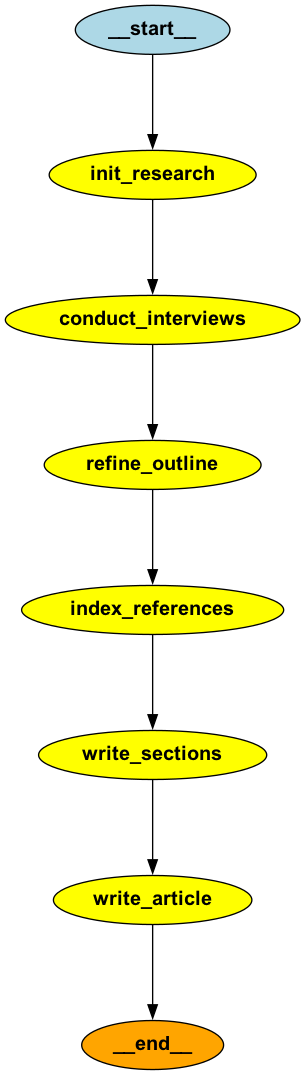

In [74]:
Image(storm.get_graph().draw_png())

In [75]:
async for step in storm.astream(
    {
        "topic": "Groq, NVIDIA, Llamma.cpp and the future of LLM Inference",
    }
):
    name = next(iter(step))
    print(name)
    print("-- ", str(step[name])[:300])
    if END in step:
        results = step

init_research
--  {'topic': 'Groq, NVIDIA, Llamma.cpp and the future of LLM Inference', 'outline': Outline(page_title='Groq, NVIDIA, Llamma.cpp and the future of LLM Inference', sections=[Section(section_title='Introduction', description='Overview of Groq, NVIDIA, Llamma.cpp, and their significance in the field of La
conduct_interviews
--  {'topic': 'Groq, NVIDIA, Llamma.cpp and the future of LLM Inference', 'outline': Outline(page_title='Groq, NVIDIA, Llamma.cpp and the future of LLM Inference', sections=[Section(section_title='Introduction', description='Overview of Groq, NVIDIA, Llamma.cpp, and their significance in the field of La
refine_outline
--  {'topic': 'Groq, NVIDIA, Llamma.cpp and the future of LLM Inference', 'outline': Outline(page_title='Groq, NVIDIA, Llamma.cpp and the Future of LLM Inference', sections=[Section(section_title='Introduction', description='An overview of the significance and roles of Groq, NVIDIA, and Llamma.cpp in th
index_references
--  {'topic': 'Groq,

In [82]:
article = results[END]["article"]

## Render the Wiki

Now we can render the final wiki page!

In [83]:
from IPython.display import Markdown

# We will down-header the sections to create less confusion in this notebook
Markdown(article.replace("\n#", "\n##"))

# Large Language Model (LLM) Inference Technologies

### Contents
1. [Introduction](#Introduction)
2. [Groq's Advancements in LLM Inference](#Groqs-Advancements-in-LLM-Inference)
3. [NVIDIA's Contributions to LLM Inference](#NVIDIAs-Contributions-to-LLM-Inference)
   1. [Hardware Innovations](#Hardware-Innovations)
   2. [Software Solutions](#Software-Solutions)
   3. [Research and Development](#Research-and-Development)
4. [Llamma.cpp: Accelerating LLM Inference](#Llammacpp-Accelerating-LLM-Inference)
5. [The Future of LLM Inference](#The-Future-of-LLM-Inference)
6. [References](#References)

### Introduction

The advent of million-plus token context window language models, such as Gemini 1.5, has significantly advanced the field of artificial intelligence, particularly in natural language processing (NLP). These models have expanded the capabilities of machine learning in understanding and generating text over vastly larger contexts than previously possible. This leap in technology has paved the way for transformative applications across various domains, including the integration into Retrieval-Augmented Generation (RAG) systems to produce more accurate and contextually rich responses. 

### Groq's Advancements in LLM Inference

Groq has introduced the Groq Linear Processor Unit (LPU), a purpose-built hardware architecture for LLM inference. This innovation positions Groq as a leader in efficient and high-performance LLM processing by optimizing the hardware specifically for LLM tasks. The Groq LPU dramatically reduces latency and increases the throughput of LLM inferences, facilitating advancements in a wide range of applications, from natural language processing to broader artificial intelligence technologies[1].

### NVIDIA's Contributions to LLM Inference

NVIDIA has played a pivotal role in advancing LLM inference through its GPUs, optimized for AI and machine learning workloads, and specialized software frameworks. The company's GPU architecture and software solutions, such as the CUDA Deep Neural Network library (cuDNN) and the TensorRT inference optimizer, are designed to accelerate computational processes and improve LLM performance. NVIDIA's active participation in research and development further underscores its commitment to enhancing the capabilities of LLMs[1].

#### Hardware Innovations

NVIDIA's GPU architecture facilitates high throughput and parallel processing for LLM inference tasks, significantly reducing inference time and enabling complex models to be used in real-time applications.

#### Software Solutions

NVIDIA's suite of software tools, including cuDNN and TensorRT, optimizes LLM performance on its hardware, streamlining the deployment of LLMs by improving their efficiency and reducing latency.

#### Research and Development

NVIDIA collaborates with academic and industry partners to develop new techniques and models that push the boundaries of LLM technology, aiming to make LLMs more powerful and applicable across a broader range of tasks.

### Llamma.cpp: Accelerating LLM Inference

Llamma.cpp is a framework developed to enhance the speed and efficiency of LLM inference. By integrating specialized hardware, such as Groq's LPU, and optimizing for parallel processing, Llamma.cpp significantly accelerates computation times and reduces energy consumption. The framework supports million-plus token context window models, enabling applications requiring deep contextual understanding and extensive knowledge retrieval[1][2].

### The Future of LLM Inference

The future of LLM inference is poised for transformative changes with advances in purpose-built hardware architectures like Groq's LPU. These innovations promise to enhance the speed and efficiency of LLM processing, leading to more interactive, capable, and integrated AI applications. The potential for advanced hardware and sophisticated LLMs to enable near-instantaneous processing of complex queries and interactions opens new avenues for research and application in various fields, suggesting a future where AI is seamlessly integrated into society[1][2].

### References

[1] "Groq's LPU: Advancing LLM Inference Efficiency," Prompt Engineering. https://promptengineering.org/groqs-lpu-advancing-llm-inference-efficiency/

[2] "The Speed of Thought: Harnessing the Fastest LLM with Groq's LPU," Medium. https://medium.com/@anasdavoodtk1/the-speed-of-thought-harnessing-the-fastest-llm-with-groqs-lpu-11bb00864e9c